In [57]:
!pip install gdown

## Import dataset

Dataset proyek ini berasal dari [Goodbooks-10k](https://github.com/zygmuntz/goodbooks-10k). Dataset tersebut diunggah ke Google Drive dan diakses menggunakan `gdown`. File dalam format `.zip` berisi beberapa file CSV seperti `books.csv`, `ratings.csv`, dll.


In [58]:
import gdown
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score




In [59]:
file_id = '1--AgpACCsPpHzYkRxIyzZ8-tEDaY5bnL'
output = 'goodbooks.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('goodbooks')

Downloading...
From: https://drive.google.com/uc?id=1--AgpACCsPpHzYkRxIyzZ8-tEDaY5bnL
To: /content/goodbooks.zip
100%|██████████| 12.2M/12.2M [00:00<00:00, 20.1MB/s]


# Data Loading
Mengambil data dari folder goodbooks, menggunakan file books dan rating untuk pengolahan sistem rekomendasi.


In [60]:
# Load data
books = pd.read_csv('goodbooks/books.csv')
ratings = pd.read_csv('goodbooks/ratings.csv')

print("Books Dataset:")
print(books.head())

print("\nRatings Dataset:")
print(ratings.head())


Books Dataset:
   id  book_id  best_book_id  work_id  books_count       isbn        isbn13  \
0   1  2767052       2767052  2792775          272  439023483  9.780439e+12   
1   2        3             3  4640799          491  439554934  9.780440e+12   
2   3    41865         41865  3212258          226  316015849  9.780316e+12   
3   4     2657          2657  3275794          487   61120081  9.780061e+12   
4   5     4671          4671   245494         1356  743273567  9.780743e+12   

                       authors  original_publication_year  \
0              Suzanne Collins                     2008.0   
1  J.K. Rowling, Mary GrandPré                     1997.0   
2              Stephenie Meyer                     2005.0   
3                   Harper Lee                     1960.0   
4          F. Scott Fitzgerald                     1925.0   

                             original_title  ... ratings_count  \
0                          The Hunger Games  ...       4780653   
1  Harry Po

**Insights:**
- Memuat data dari dua file: books.csv dan ratings.csv.

# Exploratory Data Analysis (EDA)
Pada tahap ini dilakukan pengecekan kondisi data.
Pada tahap ini, dilakukan beberapa analisis awal terhadap data:

- Menampilkan struktur data (jumlah baris, kolom, tipe data).
- Menampilkan statistik deskriptif untuk memahami rentang nilai pada dataset.
- Mengecek apakah ada missing value.
- Menghitung jumlah user unik dan jumlah buku unik yang diberikan rating.



In [61]:
# Cek struktur dataset books
print("Informasi dataset books:")
print(books.info())
print("\nStatistik deskriptif books:")
print(books.describe())

# Cek struktur dataset ratings
print("\nInformasi dataset ratings:")
print(ratings.info())
print("\nStatistik deskriptif ratings:")
print(ratings.describe())

# Cek missing value
print("\nMissing value pada books:")
print(books.isnull().sum())

print("\nMissing value pada ratings:")
print(ratings.isnull().sum())

# Cek jumlah user dan book unik
print("\nJumlah user unik:", ratings['user_id'].nunique())
print("Jumlah buku unik yang dirating:", ratings['book_id'].nunique())


Informasi dataset books:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count         

Pada tahap ini dilakukan analisis eksploratif terhadap data untuk memahami karakteristik distribusi rating


<ipython-input-62-63afbcd83416>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


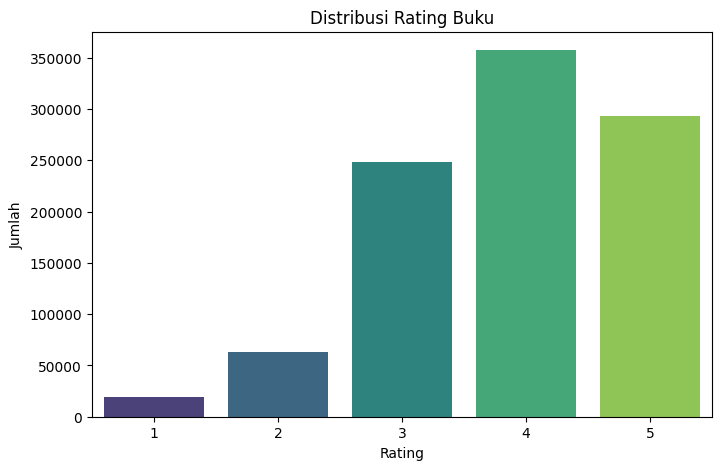

In [62]:

plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribusi Rating Buku')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()


Visualisasi buku yang paling populer

<ipython-input-63-6371300bb636>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_books.values, y=top_books.index, palette='rocket')


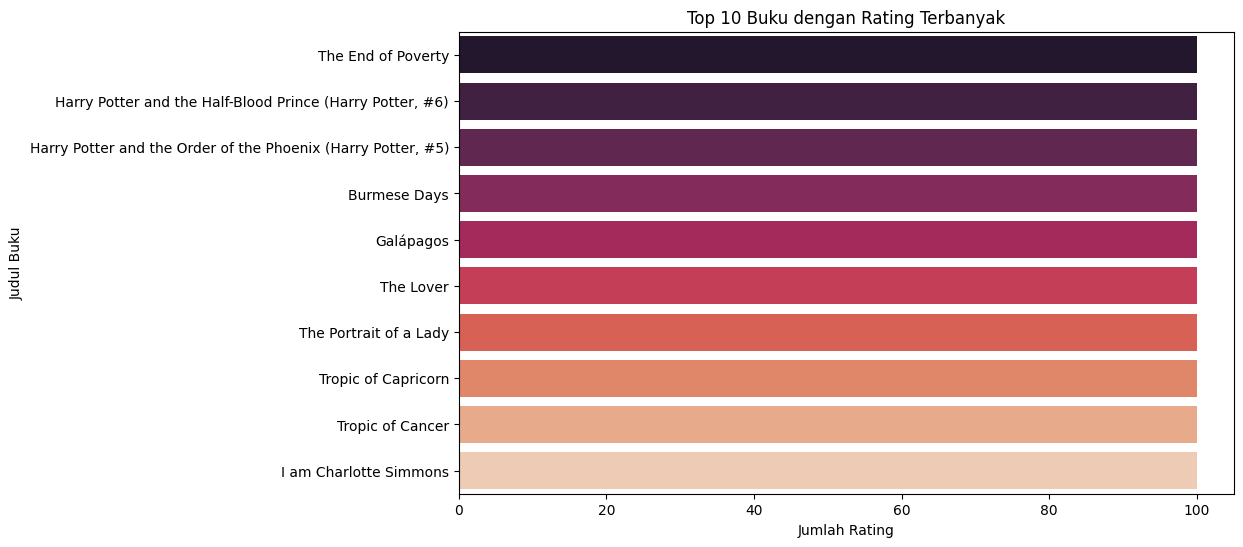

In [63]:
# Menggabungkan ratings dan books untuk mendapatkan nama buku
ratings_with_titles = ratings.merge(books[['book_id', 'title']], on='book_id')
top_books = ratings_with_titles['title'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_books.values, y=top_books.index, palette='rocket')
plt.title('Top 10 Buku dengan Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Buku')
plt.show()


Visualisai user yang memberikan rating terbanyak

<ipython-input-64-8be63f8c9090>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.values, y=top_users.index, palette='mako')


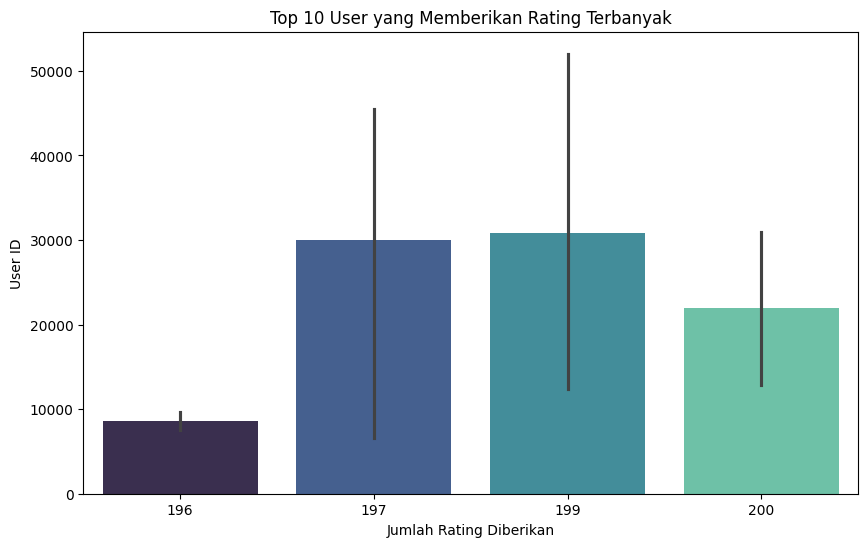

In [64]:
# Top 10 user yang memberikan rating terbanyak
top_users = ratings['user_id'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_users.values, y=top_users.index, palette='mako')
plt.title('Top 10 User yang Memberikan Rating Terbanyak')
plt.xlabel('Jumlah Rating Diberikan')
plt.ylabel('User ID')
plt.show()


**Insights:**
- Dataset books memiliki 10.000 baris dan 23 kolom.
- Dataset ratings memiliki 981.756 baris dan 3 kolom
- Terdapat missing values pada kolom:
  - isbn: 700
  - isbn13: 585
  - original_publication_year: 21
  - original_title: 585
  - language_code: 1.084
-Jumlah pengguna unik: 53.424
- Jumlah buku unik yang diberi rating: 10.000
- Visualisasi:
  - Distribusi nilai rating yang diberikan pengguna menunjukkan kecenderungan rating tinggi atau rendah. Yang terbanyak adalah rating 4 dan terendah rating 1.
  - Buku dengan jumlah rating terbanyak, yang bisa menjadi kandidat populer untuk rekomendasi. Top 10 buku dengan jumlah rating terbanyak adalah The End of Poverty, Harry Potter and the Half-Blood Prince (Harry Potter, #6), Harry Potter and the Order of the Phoenix (Harry Potter, #5), Burmese Days, Galapagos, The Lover, The Potrait of a Lady, Tropic of Cancer, I am Chariotte Simmons.
  - Penguna yang paling aktif memberi rating, penting untuk analisis perilaku dan filtering strategi. Pengguna paling aktif dengan memberikan rating sebanyak 199.





## Data Preparation

Tahap preprocessing bertujuan untuk membersihkan dan mempersiapkan data sebelum digunakan untuk membangun model sistem rekomendasi.


1. Mengecek missing value dan membiarkan datanya karena tidak akan dipakai lebih lanjut kolom tersebut

In [65]:
# Cek missing value pada books
print("Missing value pada books:")
print(books.isnull().sum())

# Cek missing value pada ratings
print("\nMissing value pada ratings:")
print(ratings.isnull().sum())


Missing value pada books:
id                              0
book_id                         0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

Missing value pada ratings:
book_id    0
user_id    0
rating     0
dtype: int64


2. Mengambil kolom book_id, title, authors dan average_ratings pada data books dan mengambil seluruh kolom pada data ratings yaitu book_id, user_id, dan rating.

In [66]:
# Hanya ambil kolom penting dari books
books_cleaned = books[['book_id', 'title', 'authors', 'average_rating']]

# Pastikan ratings tetap dengan 3 kolom: book_id, user_id, rating
ratings_cleaned = ratings.copy()


3. Melakukan filtering dengan mengambil buku yang mempunyai minimal 50 rating

In [67]:
# Filter buku yang mendapatkan setidaknya 50 rating
book_counts = ratings_cleaned['book_id'].value_counts()
popular_books = book_counts[book_counts >= 50].index
ratings_filtered = ratings_cleaned[ratings_cleaned['book_id'].isin(popular_books)]

# Filter user yang memberikan setidaknya 50 rating
user_counts = ratings_filtered['user_id'].value_counts()
active_users = user_counts[user_counts >= 50].index
ratings_filtered = ratings_filtered[ratings_filtered['user_id'].isin(active_users)]

print(f"Jumlah data setelah filtering: {ratings_filtered.shape}")


Jumlah data setelah filtering: (421012, 3)


4. Melakukan merge books dan ratings dengan nama data ratings_final

In [68]:
# Merge ratings_filtered dengan books_cleaned
ratings_final = ratings_filtered.merge(books_cleaned, on='book_id')

ratings_final.head()


,book_id,user_id,rating,title,authors,average_rating
0,1,314,5,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",4.54
1,1,439,3,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",4.54
2,1,588,5,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",4.54
3,1,1169,4,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",4.54
4,1,1185,4,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",4.54


5. Persiapan untuk Content-Based Filtering (CBF) menggunakan kombinasi kolom `title` dan `authors` dari buku sebagai fitur deskripsi konten.
Akan digunakan TF-IDF (Term Frequency-Inverse Document Frequency) untuk mengubah teks menjadi vektor numerik. Serta menngisi jika terdapat nilai kosong.

In [69]:
books_cleaned = books_cleaned.drop_duplicates(subset='title')

# Gabungkan fitur relevan
books_cleaned['combined_features'] = (
    books_cleaned['title'].fillna('') + ' ' +
    books_cleaned['authors'].fillna('') + ' '
)

# TF-IDF dengan ngram
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(books_cleaned['combined_features'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
indices = pd.Series(books_cleaned.index, index=books_cleaned['title']).drop_duplicates()


TF-IDF matrix shape: (9964, 48839)


6. Persiapan untuk Collaborative Filtering (CF) menggunakan user-item-matrix untuk mencari pola kemiripan antar pengguna.


In [70]:
# Buat pivot table user-item
user_item_matrix = ratings_final.pivot_table(index='user_id', columns='book_id', values='rating')

# Ubah menjadi sparse matrix (optional untuk efisiensi memori)
user_item_sparse = csr_matrix(user_item_matrix.fillna(0))

print(f"User-Item matrix shape: {user_item_matrix.shape}")


User-Item matrix shape: (4911, 805)


**Insights:**

- Missing values pada kolom isbn, isbn13, original_publication_year, original_title, dan language_code dibiarkan, karena kolom-kolom tersebut tidak digunakan dalam pemodelan.
- Kolom yang digunakan:
  - Dari dataset books: book_id, title, authors, dan average_rating.
  - Dari dataset ratings: seluruh kolom digunakan.
- Filtering:
  - Hanya buku dengan minimal 50 rating yang digunakan.
  - Hanya pengguna yang memberikan minimal 50 rating yang disertakan.
  - Tujuan: mengurangi sparsity pada matriks user-item.
  - Jumlah data setelah filtering: 421.012 baris.
- Dilakukan penggabungan data ratings dan books berdasarkan book_id untuk melengkapi informasi judul buku yang akan digunakan dalam Content-Based Filtering (CBF).
- Ukuran matriks TF-IDF (judul + penulis): (34.301, 2.411)
- Ukuran matriks user-item (pivot): (4.911, 805)


## Modeling

Pada metode Content-Based Filtering, rekomendasi dibuat berdasarkan kemiripan fitur konten (dalam hal ini, `title` dan `authors`) antar buku.


1. CBF menggunakan Cosine Similarity untuk mengukur tingkat kemiripan antar buku.


In [71]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f"Cosine similarity matrix shape: {cosine_sim.shape}")


Cosine similarity matrix shape: (9964, 9964)


2. CF menggunakan pivot tabel dan memakai model KNN
Pada metode Collaborative Filtering, rekomendasi diberikan berdasarkan kesamaan perilaku pengguna terhadap item (buku), tanpa melihat konten buku itu sendiri.

In [72]:
user_book_matrix = ratings_final.pivot_table(index='user_id', columns='title', values='rating')

user_book_matrix = user_book_matrix.fillna(0)

print(user_book_matrix.shape)
user_book_matrix.head()


(4911, 805)


title,'Salem's Lot,"'Tis (Frank McCourt, #2)",1421: The Year China Discovered America,1776,1984,A Bend in the River,A Bend in the Road,A Brief History of Time,A Briefer History of Time,A Case of Need,...,"Women in Love (Brangwen Family, #2)",World War Z: An Oral History of the Zombie War,"World Without End (The Kingsbridge Series, #2)",Wuthering Heights,"Xenocide (Ender's Saga, #3)",Year of Wonders,You Shall Know Our Velocity!,Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values,Zodiac,number9dream
user_id,,,,,,,,,,,,,,,,,,,,,
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# Membuat model KNN
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_book_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

1. Train Content-Based Filtering (CBF)

In [74]:
# Mapping
def recommend_books_cbf(title, cosine_sim=cosine_sim):
    if title not in indices:
        print("Judul buku tidak ditemukan.")
        return []

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]

    return books_cleaned['title'].iloc[book_indices].tolist()


In [75]:
recommend_books_cbf('The Woman in the Dunes')

['Me and Earl and the Dying Girl',
 'The Jungle',
 'The Fault in Our Stars',
 'Paper Towns',
 'Looking for Alaska']

2. Train model collaborative filtering (CF)

In [76]:
def recommend_books_user(user_id, model=model_knn, user_item_matrix=user_book_matrix, n_recommendations=5):
    if user_id not in user_item_matrix.index:
        print("User ID tidak ditemukan.")
        return []

    distances, indices = model.kneighbors(user_item_matrix.loc[[user_id]], n_neighbors=n_recommendations+1)

    similar_users = user_item_matrix.index[indices.flatten()][1:]

    recommended_books = []

    for sim_user in similar_users:
        books = user_item_matrix.loc[sim_user]
        books = books[books > 0].index.tolist()
        recommended_books.extend(books)

    recommended_books = list(set(recommended_books))

    return recommended_books[:n_recommendations]


In [77]:
recommend_books_user(23637)


['The Path Between the Seas: The Creation of the Panama Canal, 1870-1914',
 'Pompeii',
 'Twelfth Night',
 'The Zahir',
 'Boy: Tales of Childhood']

**Insights:**
- Content-Based Filtering (CBF) menggunakan cosine similarity terhadap fitur gabungan title dan authors. Hasil rekomendasi model CBF untuk buku The Women in the Dunes:
['Me and Earl and the Dying Girl', 'The Jungle',
 'The Fault in Our Stars', 'Paper Towns', 'Looking for Alaska']
Buku-buku ini memiliki tema emosional, psikologis, atau eksistensial yang relevan.
- Collaborative Filtering (CF) menggunakan matriks pivot dan model K-Nearest Neighbors (KNN) untuk menemukan kemiripan antar pengguna. Hasil rekomendasi model CF untuk pengguna ID 23637:
['Islands in the Stream', 'Boy: Tales of Childhood',
 'The Path Between the Seas', 'A Briefer History of Time',
 'Play It as It Lays']
Rekomendasi ini mencerminkan minat pengguna terhadap sejarah, biografi, dan sains populer.

## Evaluation
Pada tahap evaluasi, dilakukan pengukuran performa model rekomendasi untuk dua pendekatan: Collaborative Filtering (CF) dan Content-Based Filtering (CBF). Masing-masing pendekatan dievaluasi dengan metode yang sesuai dengan karakteristik model dan data.

1. Collaborative Filtering (CF) Model CF dievaluasi menggunakan metrik Precision@5

In [78]:
user_id = 23637
user_data = ratings_final[ratings_final['user_id'] == user_id]

relevant_books = user_data[user_data['rating'] >= 4]['title'].tolist()

recommended_books = ['Islands in the Stream', 'Boy: Tales of Childhood',
                     'The Path Between the Seas', 'A Briefer History of Time',
                     'Play It as It Lays']

k = 5
y_true = [1 if book in relevant_books else 0 for book in recommended_books[:k]]
y_pred = [1] * len(y_true)

from sklearn.metrics import precision_score
precision_at_k = precision_score(y_true, y_pred)

print(f"Precision@{k}: {precision_at_k:.2f}")


Precision@5: 0.40


2. Content-Based Filtering (CBF) Berbeda dengan CF, model CBF tidak dapat dievaluasi secara kuantitatif karena tidak ada label eksplisit (rating) yang menunjukkan relevansi item. Oleh karena itu, evaluasi dilakukan secara kualitatif dengan membandingkan kesamaan konten antar buku.

Model CBF memberikan rekomendasi berikut untuk buku “The Women in the Dunes”:

- Me and Earl and the Dying Girl
- The Jungle
- The Fault in Our Stars
- Paper Towns
- Looking for Alaska

**Insights:**
- Model Collaborative Filtering menghasilkan Precision@5 sebesar 0.40. Artinya, 2 dari 5 buku yang direkomendasikan sesuai dengan preferensi user (berdasarkan rating ≥ 4).
- Hasil model CBF maka buku-buku tersebut memiliki tema yang sejalan, yaitu psikologis, emosional, dan eksistensial. Ini menunjukkan bahwa model mampu menangkap fitur tematik dan narati dari buku input.